In [1]:
import os
import json
import hashlib
import numpy as np
from qcelemental import constants
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from functions import zetacolors, extrapolations, getFuncPars, prettifyBasis, prettifyFunc

In [2]:
l7ref = {}
with open(os.path.join("..", "external", "l7.json"), "r") as infile:
    jsdata = json.load(infile)
    for k, v in jsdata.items():
        l7ref[k] = v[0] * constants.cal2J

In [3]:
results = {}
rfns = os.listdir(os.path.join("..", "data", "L7"))
for fn in rfns:
    if fn.endswith("json"):
        with open(os.path.join("..", "data", "L7", fn), "r") as infile:
            data = json.load(infile)
        func, basis, mol = data["tag"].split()
        if func not in results:
            results[func] = {}
        if basis not in results[func]:
            results[func][basis] = {}
        results[func][basis][mol] = {
            "tot": data["return_result"],
            "fctl": data["extras"]["qcvars"]["DFT FUNCTIONAL TOTAL ENERGY"],
            "dh": data["extras"]["qcvars"].get("DOUBLE-HYBRID CORRECTION ENERGY", 0),
            "disp": data["extras"]["qcvars"].get("DISPERSION CORRECTION ENERGY", 0),
            "nl": data["extras"]["qcvars"].get("DFT VV10 ENERGY", 0)
        }

In [4]:
def expsqrt(Ehi, Elo, Zhi, Zlo, a):
    b_div = 1 / (np.exp(-1 * a * np.sqrt(Zhi)) - np.exp(-1 * a * np.sqrt(Zlo)))
    b_mul = np.exp(-1 * a * np.sqrt(Zhi))
    b = (Ehi - Elo) * b_div
    Einf = Ehi - b * b_mul
    return Einf

def power(Ehi, Elo, Zhi, Zlo, a):
    b_div = 1 / (Zhi**(-1 * α) - Zlo**(-1 * α))
    b_mul = Zhi**(-1 * α)
    b = (Ehi - Elo) * b_div
    Einf = Ehi - b * b_mul
    return Einf

aes = {}
for func in results:
    aes[func] = {}
    for basis in results[func]:
        aes[func][basis] = []
        for mol in l7ref:
            try:
                lmol = mol.lower()
                Eint = results[func][basis][f"{lmol}_d"]["tot"] 
                Eint = Eint - (results[func][basis][f"{lmol}_a"]["tot"] + results[func][basis][f"{lmol}_b"]["tot"])
                Eint = Eint * constants.hartree2kJmol 
                aes[func][basis].append(abs(l7ref[mol] - Eint))
            except KeyError:
                continue
for func, basis in [
    ["b97m-v", "pcseg-[12]"], 
    ["m062x-d3", "def2-[st]zvpd"], 
    ["dsd-blyp-d3bj", "pcseg-[12]"],
    ["dsd-pbep86-nl", "def2-[st]zvpd"],
    ["b3lyp-d3bj", "def2-[st]zvpd"],
    ["dsd-pbep86-nl", "pcseg-[12]"],
    ["b2plyp-d3bj", "aug-pcseg-[12]"]]:
        aes[func][basis] = []
        ax, ac = getFuncPars(func)
        Blo = extrapolations[basis]["comps"][0]
        Bhi = extrapolations[basis]["comps"][1]
        Zlo = extrapolations[basis]["zetas"][0]
        Zhi = extrapolations[basis]["zetas"][1]
        α = extrapolations[basis]["α0"] + ax * extrapolations[basis]["αx"] + ac * extrapolations[basis]["αc"]
        for mol in l7ref:
            lmol = mol.lower()
            Ed = expsqrt(results[func][Bhi][f"{lmol}_d"]["fctl"],
                             results[func][Blo][f"{lmol}_d"]["fctl"],
                             Zhi, Zlo, α) + \
                 power(results[func][Bhi][f"{lmol}_d"]["dh"],
                             results[func][Blo][f"{lmol}_d"]["dh"],
                             Zhi, Zlo, 2.4) + \
                 results[func][Bhi][f"{lmol}_d"]["disp"]
                
            Ea = expsqrt(results[func][Bhi][f"{lmol}_a"]["fctl"],
                             results[func][Blo][f"{lmol}_a"]["fctl"],
                             Zhi, Zlo, α) + \
                 power(results[func][Bhi][f"{lmol}_a"]["dh"],
                             results[func][Blo][f"{lmol}_a"]["dh"],
                             Zhi, Zlo, 2.4) + \
                 results[func][Bhi][f"{lmol}_a"]["disp"]
            
            Eb = expsqrt(results[func][Bhi][f"{lmol}_b"]["fctl"],
                             results[func][Blo][f"{lmol}_b"]["fctl"],
                             Zhi, Zlo, α) + \
                 power(results[func][Bhi][f"{lmol}_b"]["dh"],
                             results[func][Blo][f"{lmol}_b"]["dh"],
                             Zhi, Zlo, 2.4) + \
                 results[func][Bhi][f"{lmol}_b"]["disp"]
            
            Eint = Ed - (Ea + Eb)
            Eint = Eint * constants.hartree2kJmol 
            aes[func][basis].append(abs(l7ref[mol] - Eint))

In [5]:
for func in aes:
    for basis in sorted(aes[func]):
        tag = func + "/" + basis
        if len(aes[func][basis]) == 7:
            print(f"{tag:30}: {np.mean(aes[func][basis]):5.2f} {np.max(aes[func][basis]):6.2f}")
        elif len(aes[func][basis]) >= 1:
            print(f"{tag:30}: {np.mean(aes[func][basis]):5.2f} {len(aes[func][basis])}")

dsd-blyp-d3bj/pcseg-1         : 34.21  68.64
dsd-blyp-d3bj/pcseg-2         : 32.10  67.90
dsd-blyp-d3bj/pcseg-3         : 27.67  57.36
dsd-blyp-d3bj/pcseg-[12]      : 29.07  62.69
b2plyp-d3bj/aug-pcseg-1       : 70.70 134.36
b2plyp-d3bj/aug-pcseg-2       : 25.14  49.55
b2plyp-d3bj/aug-pcseg-3       : 13.15  26.28
b2plyp-d3bj/aug-pcseg-[12]    : 15.40  31.58
m062x-d3/def2-[st]zvpd        :  4.12  13.73
m062x-d3/def2-qzvpd           :  3.30  10.86
m062x-d3/def2-svpd            : 31.38  56.09
m062x-d3/def2-tzvpd           :  4.16  11.95
dsd-pbep86-nl/def2-[st]zvpd   : 30.86  53.27
dsd-pbep86-nl/def2-qzvpd      : 14.99  30.20
dsd-pbep86-nl/def2-svpd       : 82.47 153.33
dsd-pbep86-nl/def2-tzvpd      : 33.21  57.91
dsd-pbep86-nl/pcseg-1         : 35.55  65.61
dsd-pbep86-nl/pcseg-2         : 24.85  47.96
dsd-pbep86-nl/pcseg-[12]      : 20.13  39.46
b97m-v/pcseg-1                : 29.16  59.28
b97m-v/pcseg-2                :  5.54  11.98
b97m-v/pcseg-3                :  4.69  10.71
b97m-v/pcs

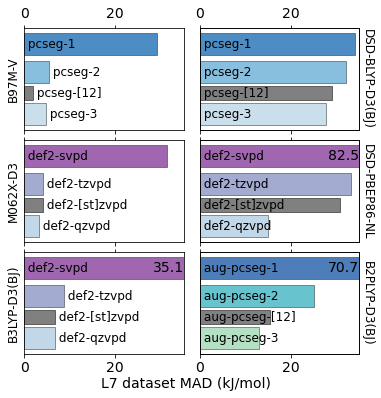

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1, figure=fig)
ax = []
ax.append(plt.subplot(grid[0:1, 0:1]))
ax.append(plt.subplot(grid[0:1, 1:2]))
ax.append(plt.subplot(grid[1:2, 0:1]))
ax.append(plt.subplot(grid[1:2, 1:2]))
ax.append(plt.subplot(grid[2:3, 0:1]))
ax.append(plt.subplot(grid[2:3, 1:2]))

graphdata = [
    ["b97m-v", ["pcseg-1", "pcseg-2", "pcseg-3", "pcseg-[12]"], [0, 6]],
    ["dsd-blyp-d3bj", ["pcseg-1", "pcseg-2", "pcseg-3", "pcseg-[12]"], [22, 34]],
    ["m062x-d3", ["def2-svpd", "def2-tzvpd", "def2-qzvpd", "def2-[st]zvpd"], [0, 6]],
    ["dsd-pbep86-nl", ["def2-svpd", "def2-tzvpd", "def2-qzvpd", "def2-[st]zvpd"], [22, 34]],
    ["b3lyp-d3bj", ["def2-svpd", "def2-tzvpd", "def2-qzvpd", "def2-[st]zvpd"], [0, 6]],
    ["b2plyp-d3bj", ["aug-pcseg-1", "aug-pcseg-2", "aug-pcseg-3", "aug-pcseg-[12]"], [22, 34]]
]

ai = 0
for fctl, bases, xy in graphdata:
    maes = [np.mean(aes[fctl][b]) for b in bases]
    ax[ai].barh([2.5,1.5,0.0], maes[:-1], color= [zetacolors[i] for i in bases[:-1]],
                edgecolor="k", linewidth=0.5, height=0.8, zorder=1, alpha=0.8)
    ax[ai].barh(0.75, maes[-1], color="0.5", edgecolor="k", height=0.5, zorder=1, alpha=1, linewidth=0.5)
    
    if ai % 2 == 0:
        ax[ai].tick_params(labelleft=True)
        ax[ai].set_ylabel(prettifyFunc(fctl), fontsize=12)
        
    else:
        ax[ai].tick_params(labelright=True)
        ty = ax[ai].twinx()
        ty.tick_params(bottom=False, top=False, left=False, right=False, 
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        ty.set_ylabel(prettifyFunc(fctl), fontsize=12, rotation=270, labelpad=15)
    
    ax[ai].tick_params(axis="y",direction="in", pad=-5)
    ax[ai].tick_params(bottom=True, top=True, left=False, right=False, 
                       labelbottom=False, labeltop=False, labelleft=True, labelright=False)
    ax[ai].set_yticks([])
    ax[ai].tick_params(axis="y",direction="in", pad=-5)
    
    ax[ai].text(0 if maes[0] > 10 else maes[0], 2.5, " " + bases[0], fontsize=12, ha="left", va="center")
    ax[ai].text(0 if maes[1] > 10 else maes[1], 1.5, " " + bases[1], fontsize=12, ha="left", va="center")
    ax[ai].text(0 if maes[2] > 10 else maes[2], 0.0, " " + bases[2], fontsize=12, ha="left", va="center")
    ax[ai].text(0 if maes[3] > 10 else maes[3], 0.75, " " + bases[3], fontsize=12, ha="left", va="center")
    ax[ai].text(35, 2.5, " " if maes[0] < 35 else f"{maes[0]:4.1f}", ha="right", va="center")
    ax[ai].set_xlim(left=0, right=35)
    ai += 1

ax[0].tick_params(labeltop=True)
ax[1].tick_params(labeltop=True)
ax[4].tick_params(labelbottom=True)
ax[5].tick_params(labelbottom=True)
fig.text(0.5, 0.04, "L7 dataset MAD (kJ/mol)", ha="center", va="bottom")
plt.show()
fig.savefig(os.path.join("..","output","fig_l7.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")